Info in <TCanvas::Print>: png file s12_vertical.png has been created
Info in <TCanvas::Print>: png file s18_vertical.png has been created
Info in <TCanvas::Print>: png file s12_radial.png has been created
Info in <TCanvas::Print>: png file s18_radial.png has been created


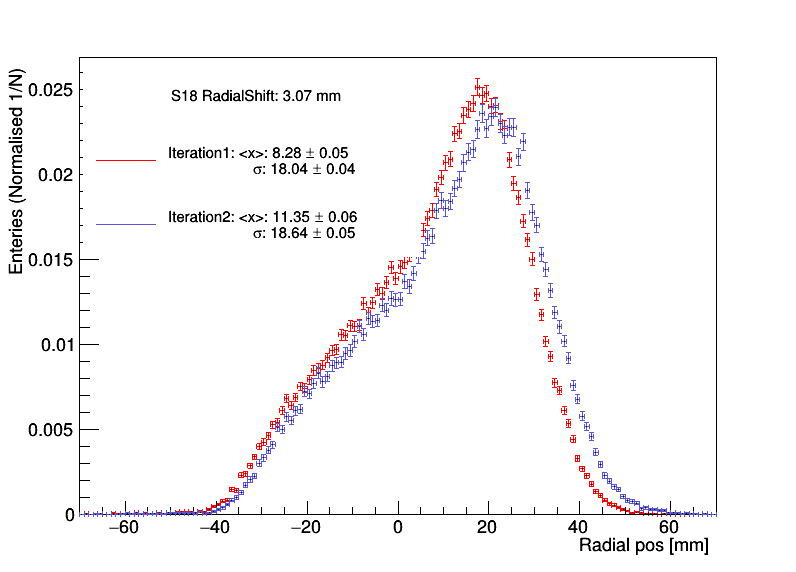

In [64]:
# Juoyer ROOT import 
import sys
sys.path.append("/usr/local/Cellar/root/6.14.04_2/lib/root")
# ROOT includes 
from ROOT import TH1D, TH2D, TF1, TCanvas, TFile, gStyle, TLegend, gROOT

#Define constant paths and labels 
station12Path = "Extrapolation/vertices/station12/"
station18Path = "Extrapolation/vertices/station18/"
scr_nominal = "/Users/gleb/software/alignTrack/mpIIDESY/15922/trackRecoPlots_15922_Iter1.root"
scr_shift = "/Users/gleb/software/alignTrack/mpIIDESY/15922_Iter2/trackRecoPlots_15922_Iter2.root"
stateN = 2 # nominal (0) and shift (1)

#Final plots and canvases names (looped over i_plot)
canvasName = ["s12_vertical", "s18_vertical", "s12_radial", "s18_radial"]
canvasTitle = ["S12 Vertical", "S18 Vertical", "S12 Radial", "S18 Radial"]
plotPath = [station12Path, station18Path, station12Path, station18Path]
plotName=["h_verticalPos_vs_time", "h_verticalPos_vs_time", "h_radialPos_vs_time", "h_radialPos_vs_time"] # TFile TH2 names  

#Legen labels (looped over i_state)
legendName = ["Iteration1", "Iteration2"]
colorLine = [2, 9] # red, blue
colorHisto = [2, 9] # red, blue 

#Open TFiles (looped over i_state)
scrFile_nominal = TFile.Open(scr_nominal)
scrFile_shift = TFile.Open(scr_shift)
fileName = [scrFile_nominal, scrFile_shift] # nominal (0) and shift (1)

#Global empty containers to be filled for vertical or radial (in the main loop)
result = "-1"
mean = -1
mean_error = -1 
sd = -1 
sd_error = -1 

meanArray=[] # for the final FoM shift-nominal 

###### Plotting ##########

for i_plot in range(0, len(canvasName)):

    #Make new canvas for plots (4 in total)
    canvas = TCanvas(str(canvasName[i_plot]), " ", 800, 600)
    
    #Postion legend once per main loop accordingly 
    if( canvasName[i_plot] == "s12_vertical" or  canvasName[i_plot] == "s18_vertical"):
        legend =  TLegend(0.87, 0.87, 0.59, 0.55)
    if( canvasName[i_plot] == "s12_radial" or  canvasName[i_plot] == "s18_radial"):
        legend =  TLegend(0.105, 0.89, 0.53, 0.55)   
           
    #Loop over the 2 iterations (nominal and shift)
    for i_state in range(0, stateN):
    
        #Get the TH2F 
        histo_2D = fileName[i_state].Get(str(plotPath[i_plot])+plotName[i_plot])
        
        #Apply 30 us time cut 
        first_bin = histo_2D.GetXaxis().FindBin(30.0)
        
        tmpNameTH1 = "tmpNameTH1_"+str(i_state) # assign a new "name pointer" to the TH1 object for each loop 
        hist_1D = histo_2D.ProjectionY(tmpNameTH1, first_bin, -1)
        hist_1D.SetTitle("")
        hist_1D.GetXaxis().SetRangeUser(-70, 70) # applying a maximum range cut 
        norm = hist_1D.GetEntries();
        hist_1D.Scale(1/norm); # normalise the histo 
        hist_1D.GetYaxis().SetTitle("Enteries (Normalised 1/N)")
        hist_1D.GetYaxis().SetTitleOffset(1.4);
        histo1D.append(hist_1D)
            
        #Do a fit for vertical only 
        if( canvasName[i_plot] == "s12_vertical" or  canvasName[i_plot] == "s18_vertical"):
            
            #Define a Gaussian fit function between -30 to 30 mm 
            tmpNameTF1 = "tmpNameTF1_"+str(i_state)
            gF = TF1(tmpNameTF1, "gaus", -30.0, 30.0)
            
            #Draw on canvas 
            gF.SetLineColor(colorLine[i_state])
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")
                hist_1D.Fit(gF, "QR") # quite fit over the specified range above
                
            else:
                hist_1D.Draw("E1 same")
                hist_1D.Fit(gF, "QR same") # quite fit over the specified range above
            
            
            #Get stats from fit 
            mean = round(gF.GetParameter(1), 2)
            mean_error = round(gF.GetParError(1), 2)
            sd = round(gF.GetParameter(2), 2)
            sd_error = round(gF.GetParError(2), 2)
            result = "<y>"
            legenObject = gF
            meanArray.append(mean)

        #Extract mean from a radial histogram only  
        if( canvasName[i_plot] == "s12_radial" or  canvasName[i_plot] == "s18_radial"):
            
            #Draw on canvas 
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")
                
            else:
                hist_1D.Draw("E1 same")
            
            #Get stats from hist 
            mean = round(hist_1D.GetMean(), 2)
            mean_error = round(hist_1D.GetMeanError(), 2)
            sd = round(hist_1D.GetRMS(), 2)
            sd_error = round(hist_1D.GetRMSError(), 2)
            result = "<x>"
            legenObject = hist_1D
            meanArray.append(mean)
            
            
        #take care of the legend
        legenValue1 = str(legendName[i_state])+": "+str(result)+": "+str(mean)+" #pm "+str(mean_error) 
        legenValue2 = "#sigma: "+str(sd)+" #pm "+str(sd_error)
        legend.AddEntry(legenObject,"#splitline{"+str(legenValue1)+"}{                 "+str(legenValue2)+"}","L") # make appropriate spacing 
        legend.SetTextSize(.028)
        legend.Draw("same")
        
    
    #Do some final massagin and save to a file
    legend.SetHeader(canvasTitle[i_plot]+"Shift: "+str(round(meanArray[1]-meanArray[0], 2))+" mm", "C"); # option "C" allows to center the header
    meanArray=[]
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(0)
    gStyle.SetLegendBorderSize(0)
    gStyle.SetLegendTextSize(0.023)
    canvas.Draw()
    canvas.Print(str(canvasName[i_plot])+".png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: pval
Info in <TCanvas::Print>: png file pval.png has been created
Info in <TCanvas::Print>: png file pval.png has been created


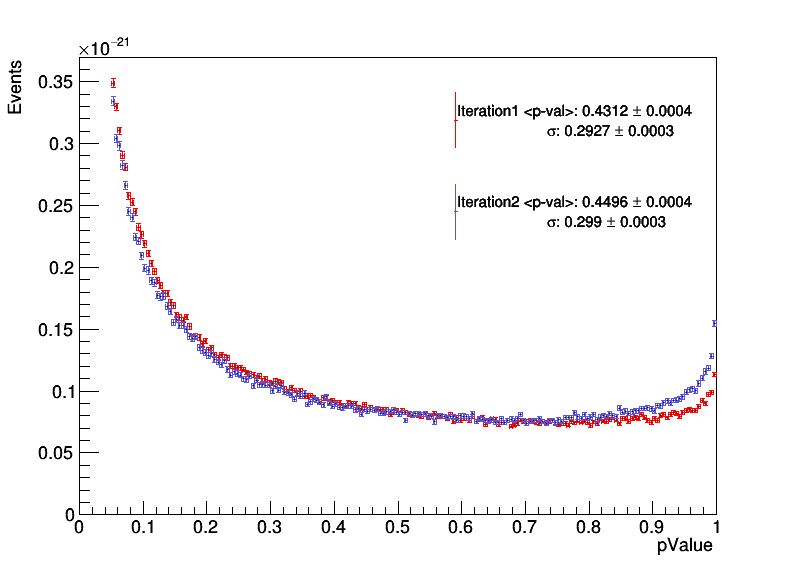

In [51]:
###Pvalue plots 

## TODO do for each station 

#redefine constants for new plotting surge 
plotPath = "TrackSummary/FitResults/pValues" 

canvas_p = TCanvas("pval", " ", 800, 600)
legend =  TLegend(0.57, 0.87, 0.59, 0.55)

for i_state in range(0, stateN):
    
    #Get the plot 
    h_pval = fileName[i_state].Get(str(plotPath))
    norm = h_pval.GetEntries();
    h_pval.Scale(1/norm); # normalise the histo
    
    mean = round(h_pval.GetMean() , 4)
    mean_error = round(h_pval.GetMeanError() , 4)
    sd = round(h_pval.GetRMS() , 4)
    sd_error = round(h_pval.GetRMSError() , 4)
    
    #Draw 
    h_pval.SetLineColor(colorHisto[i_state])
    if (i_state == 0):
        h_pval.Draw("E1")

    else:
        h_pval.Draw("E1 same")
       

#     #take care of the legend
    legenValue1 = str(legendName[i_state])+" <p-val>: "+str(mean)+" #pm "+str(mean_error) 
    legenValue2 = "#sigma: "+str(sd)+" #pm "+str(sd_error)
    legend.AddEntry(h_pval,"#splitline{"+str(legenValue1)+"}{                   "+str(legenValue2)+"}","LE") # make appropriate spacing 
    legend.SetTextSize(.028)
    legend.Draw("same")
    
    #Do some final massagin and save to a filer
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(0)
    gStyle.SetLegendBorderSize(0)
    gStyle.SetLegendTextSize(0.023)
    canvas_p.Draw()
    canvas_p.Print("pval.png")
